<a href="https://colab.research.google.com/github/dudgus1286/pandas/blob/main/%ED%85%8D%EC%8A%A4%ED%8A%B8%EB%A7%88%EC%9D%B4%EB%8B%9D/04_%ED%86%A0%ED%94%BD%EB%AA%A8%EB%8D%B8%EB%A7%81_120_%EB%8B%A4%EC%82%B0_%EC%BD%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 토픽모델링 - 문서의 주제 파악 및 분류
1. 문서들이 가지고 있는 여러가지 토픽을 찾아주는 기법
2. 토픽을 단어의 묶음으로 정의하고 하나의 문서에 여러 개의 토픽이 존재할 수 있다고 가정

### 활용분야
- 콘텐츠 추천 및 맞춤화(사용자와 상호작용한 데이터에서 관심 주제 식별)
- 고객 피드백 분석
- 소셜 미디어 데이터에서 트렌드와 이슈 식별
- 기업 내부 문서 관리

## 120 다산 콜 재단
- https://www.120dasan.or.kr/dsnc/main/main.do

### 머신러닝 분석과정
1. 토픽 모델링
  - 데이터를 학습 데이터와 시험 데이터로 나누기
  - 레이블 값을 행렬 형태로 만들기
  - 벡터화 하기
  - 예제 데이터를 시퀀스로 작성
  - 모델 작성
  - 모델 컴파일

#### 1) 라이브러리 설치 및 데이터 불러오기

In [1]:
!pip install koreanize_matplotlib

!apt -qq -y install fonts-nanum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 32.0 MB/s eta 0:00:00
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Selecting previously unselected package fonts-nanum.
(Reading database ... 121913 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib
import matplotlib.font_manager as fm

import warnings
warnings.filterwarnings("ignore")

In [3]:
for fpath in fm.findSystemFonts(fontpaths=None, fontext='ttf'):
  fm.fontManager.addfont(fpath)


plt.rc("font",family='NanumBarunGothic')

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

from sklearn.decomposition import LatentDirichletAllocation

### 1) 데이터 로드

In [6]:
# seoul-120-text.csv 가져오기
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/텍스트마이닝/data/seoul-120-text.csv')
df.shape

(2645, 5)

In [7]:
df.head()

,번호,분류,제목,내용,내용번호
0,2645,복지,아빠 육아휴직 장려금,아빠 육아휴직 장려금 업무개요 남성근로자의 육아휴직을 장려하고 양육에 따른 경...,23522464
1,2644,경제,[서울산업진흥원] 서울메이드란?,서울산업진흥원 서울메이드란 서울의 감성을 담은 다양하고 새로운 경험을 제공하기 위해...,23194045
2,2643,환경,(강북구) 정비중,강북구 정비중 업무개요 투명 폐트병을 교환보상하므로 수거율을 높이고 폐기물을 감...,23032485
3,2642,복지,"광진맘택시 운영(임산부,영아 양육가정 전용 택시)",광진맘택시 운영임산부영아 양육가정 전용 택시 업무개요 교통약자인 임산부와 영아가정...,22904492
4,2641,복지,마포 뇌병변장애인 비전센터,마포 뇌병변장애인 비전센터 마포뇌병변장애인 비전센터 운영 구분 내용 목적 학...,22477798


In [10]:
# 결측치 확인

df.isnull().sum()

번호      0
분류      0
제목      0
내용      0
내용번호    0
dtype: int64

### 2) 데이터 전처리
- 제목과 내용을 + 로 합쳐서 문서라는 컬럼 생성(중간에 공백 추가)

In [11]:
df['문서'] = df['제목'] + " " + df['내용']

In [12]:
df.head(3)

,번호,분류,제목,내용,내용번호,문서
0,2645,복지,아빠 육아휴직 장려금,아빠 육아휴직 장려금 업무개요 남성근로자의 육아휴직을 장려하고 양육에 따른 경...,23522464,아빠 육아휴직 장려금 아빠 육아휴직 장려금 업무개요 남성근로자의 육아휴직을 장...
1,2644,경제,[서울산업진흥원] 서울메이드란?,서울산업진흥원 서울메이드란 서울의 감성을 담은 다양하고 새로운 경험을 제공하기 위해...,23194045,[서울산업진흥원] 서울메이드란? 서울산업진흥원 서울메이드란 서울의 감성을 담은 다양...
2,2643,환경,(강북구) 정비중,강북구 정비중 업무개요 투명 폐트병을 교환보상하므로 수거율을 높이고 폐기물을 감...,23032485,(강북구) 정비중 강북구 정비중 업무개요 투명 폐트병을 교환보상하므로 수거율을 ...


### 3) 단어 벡터화
#### - CountVectorizer

In [18]:
# 단어들의 출현 빈도로 여러 문서 벡터화

corpus = list(df['문서'])

cvect = CountVectorizer(stop_words = ['돋움', '경우', '또는', '있습니다', '있는', '합니다'])

In [20]:
# 학습 후 변경

# cvect.fit_transform(corpus)
X = cvect.fit_transform(df['문서'])
X

<2645x56648 sparse matrix of type '<class 'numpy.int64'>'
	with 117379 stored elements in Compressed Sparse Row format>

In [23]:
# 단어 집합 확인하기

# 단어, 횟수
cvect.vocabulary_

# 단어만
cvect.get_feature_names_out()

array(['03월', '08년', '10', ..., '힘쓴다', '힘을', '힘이'], dtype=object)

In [29]:
# 단어 목록 가져와서 사전을 만들어 변수에 담기

len(cvect.get_feature_names_out())

vocab = cvect.get_feature_names_out()

In [25]:
def display_transform_dtm(cvect, corpus):
  X = cvect.fit_transform(corpus)
  dtm = X.toarray()

  return pd.DataFrame(dtm, columns = cvect.get_feature_names_out()).style.background_gradient()

In [31]:
# 희소 행렬을 Numpy array 배열로 변환하고 값 확인

pd.DataFrame(X.toarray(), columns = vocab).sum().sort_values()

03월       1
용액속에      1
용액을       1
용액이       1
용어        1
       ... 
따라      368
홈페이지    384
대한      394
서울시     578
어떻게     597
Length: 56648, dtype: int64

In [ ]:
display_transform_dtm(cvect, df['문서'])

In [36]:
#  2,645 개 문서에서 토픽 수 확인

df['분류'].value_counts()


분류
행정        1098
경제         823
복지         217
환경         124
주택도시계획     110
문화관광        96
교통          90
안전          51
건강          23
여성가족        13
Name: count, dtype: int64

### LDA 토픽 모델링
- LatentDirichletAllocation(잠재디리클레할당)
  - 주어진 문서에 대해 각 문서에 어떤 주제(토픽)들이 있는지 서술하는 확률적 토픽 분류 기법
  - 미리 알고 있는 주제별 단어 수 분포를 바탕으로, 주어진 문서에서 발견된 단어 수 분포 분석을 통해 해당 문서가 어떤 주제들을 함께 다루고 있을지 추측

In [38]:
# 모델 생성

from sklearn.decomposition import LatentDirichletAllocation

# n_components : 토픽의 수 지정
LDAModel = LatentDirichletAllocation(n_components=10, random_state=42)

In [40]:
# 모델 학습
# 2645 개 문서에서 10 개 토픽 추출

W = LDAModel.fit_transform(X)
W

array([[1.23466328e-03, 9.88887370e-01, 1.23478533e-03, ...,
        1.23479357e-03, 1.23468723e-03, 1.23468660e-03],
       [2.32582636e-03, 2.32575393e-03, 9.79067879e-01, ...,
        2.32592505e-03, 2.32570262e-03, 2.32566751e-03],
       [9.25980498e-04, 9.91665932e-01, 9.26017664e-04, ...,
        9.26025121e-04, 9.26006597e-04, 9.26004268e-04],
       ...,
       [2.63174675e-03, 2.63189922e-03, 2.63193391e-03, ...,
        9.76313482e-01, 2.63174928e-03, 2.63174609e-03],
       [3.57203197e-03, 3.57183920e-03, 3.57196180e-03, ...,
        3.57168114e-03, 9.67852926e-01, 3.57224386e-03],
       [5.00022731e-03, 5.00031539e-03, 5.00050049e-03, ...,
        5.00021707e-03, 9.54997721e-01, 5.00013988e-03]])

In [41]:
# 2645 개 문서에서 추출한 단어 56648 개를 10 개 토픽에 분류
H = LDAModel.components_
H

array([[0.1       , 0.1       , 0.1       , ..., 0.1       , 0.1       ,
        0.1       ],
       [0.1       , 0.1       , 0.1       , ..., 0.1       , 1.09999975,
        0.1       ],
       [0.1       , 0.1       , 0.1       , ..., 0.1       , 0.1       ,
        0.1       ],
       ...,
       [0.1       , 0.1       , 0.1       , ..., 0.1       , 0.1       ,
        0.1       ],
       [1.1       , 1.1       , 0.1       , ..., 1.1       , 0.1       ,
        0.1       ],
       [0.1       , 0.1       , 0.1       , ..., 0.1       , 1.1       ,
        0.1       ]])

In [42]:
W.shape, H.shape

((2645, 10), (10, 56648))

- 2,645 개의 문서에서 10개 토픽 추출 : (2645,10)
- 추출된 토픽을 기반으로 단어사전의 단어와 연동

In [44]:
df['분류'].unique().tolist()

['복지', '경제', '환경', '행정', '교통', '주택도시계획', '문화관광', '안전', '건강', '여성가족']

In [43]:
df_lda_w = pd.DataFrame(W)
# 인덱스 : 각 문서 / 컬럼 : 토픽
df_lda_w.head()

,0,1,2,3,4,5,6,7,8,9
0,0.001235,0.988887,0.001235,0.001235,0.001235,0.001235,0.001235,0.001235,0.001235,0.001235
1,0.002326,0.002326,0.979068,0.002326,0.002326,0.002326,0.002326,0.002326,0.002326,0.002326
2,0.000926,0.991666,0.000926,0.000926,0.000926,0.000926,0.000926,0.000926,0.000926,0.000926
3,0.000735,0.000735,0.000735,0.000735,0.964832,0.000735,0.029284,0.000735,0.000735,0.000735
4,0.001429,0.001429,0.987140,0.001429,0.001429,0.001429,0.001429,0.001429,0.001429,0.001429


In [46]:
df_lda_h = pd.DataFrame(H, columns=cvect.get_feature_names_out())
df_lda_h

,03월,08년,10,100명이상인,100세가,10만원,10만원상당,10명이고,10인승,10인의,...,힐링프로그램을,힐링하는,힐스테이트,힘들,힘들경우,힘들고,힘쓰고있습니다,힘쓴다,힘을,힘이
0,0.1,0.1,0.1,1.1,1.1,1.1,0.1,0.1,0.1,0.1,...,0.1,0.10000,0.1,0.1,0.1,0.1,1.1,0.1,0.1,0.1
1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,0.1,0.10000,0.1,0.1,0.1,1.1,0.1,0.1,1.1,0.1
2,0.1,0.1,0.1,0.1,0.1,0.1,1.1,0.1,0.1,0.1,...,0.1,0.10000,0.1,1.1,0.1,0.1,0.1,0.1,0.1,0.1
3,0.1,0.1,0.1,0.1,0.1,0.1,0.1,1.1,0.1,0.1,...,0.1,0.10000,1.1,0.1,0.1,0.1,0.1,0.1,0.1,1.1
4,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,0.1,0.10002,0.1,1.1,0.1,0.1,0.1,0.1,0.1,0.1
5,0.1,0.1,1.1,0.1,0.1,0.1,0.1,0.1,0.1,1.1,...,0.1,0.10000,0.1,0.1,1.1,0.1,0.1,0.1,0.1,0.1
6,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,0.1,0.10000,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
7,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,0.1,1.09998,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
8,1.1,1.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,1.1,0.10000,0.1,0.1,0.1,0.1,0.1,1.1,0.1,0.1
9,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,1.1,0.1,...,0.1,0.10000,0.1,0.1,0.1,0.1,0.1,0.1,1.1,0.1


In [48]:
df['분류'].unique().tolist()

['복지', '경제', '환경', '행정', '교통', '주택도시계획', '문화관광', '안전', '건강', '여성가족']

In [47]:
df_lda_w['content'] = df['내용']
df_lda_w['label'] = df['분류']
df_lda_w.head(10).style.background_gradient(axis=1)

,0,1,2,3,4,5,6,7,8,9,content,label
0,0.001235,0.988887,0.001235,0.001235,0.001235,0.001235,0.001235,0.001235,0.001235,0.001235,아빠 육아휴직 장려금 업무개요 남성근로자의 육아휴직을 장려하고 양육에 따른 경제적 부담을 완화함으로써 일과 가정생활의 양립 및 가족친화적인 사회환경 조성 지원대상 신청일 기준 년 이상 계속하여 서초구에 주민등록 되어 있는 아빠 육아휴직자 대상자녀 서초구에 주민등록 된 경우 신청기간 육아휴직 시작일 이후 개월부터 종료일 이후 개월 이내 신청방법 온라인 서초구청 홈페이지 경로 서초구청 홈페이지 분야별정보 복지 영유아복지 아빠육아휴직장려금 신청 바로가기 방문 동주민센터 구 여성보육과 방문 구비서류 고용센터 발행 육아휴직급여 지급결정 통지서 부 주민등록등본 부세대원 이름과 전입일자 포함 모든 구성원 주민번호 뒷자리 미포함 지원내용 매월 만원지원기간 최대 년,복지
1,0.002326,0.002326,0.979068,0.002326,0.002326,0.002326,0.002326,0.002326,0.002326,0.002326,서울산업진흥원 서울메이드란 서울의 감성을 담은 다양하고 새로운 경험을 제공하기 위해 만들어진 라이프스타일 플랫폼 브랜드로 서울이 만들고 세계가 함께 쓰는 브랜드 입니다 서울의 감성을 담은 기업과 협업하여 브랜드 상품을 발굴 사용을 원하는 중소기업에게 서울메이드 브랜드 제공 등 관련홈페이지 서울메이드 상세문의사항 서울산업진흥원 브랜드전략팀,경제
2,0.000926,0.991666,0.000926,0.000926,0.000926,0.000926,0.000926,0.000926,0.000926,0.000926,강북구 정비중 업무개요 투명 폐트병을 교환보상하므로 수거율을 높이고 폐기물을 감량하여 환경 보호에 기여 업무설명 강북구 투명 페트병 종량제봉투 교환 사업 안내 구분 내용 사업기간 교환품목 투명 페트병 유색 페트병 일회용 컵 요구르트 식품 포장용기 식용유 양념류 제외 대상 관내 구민 누구나 교환장소 관내 동 주민센터 방문 교환 목요일 한정 처리방법 투명 페트병 개당 종량제봉투 장 교환 이하 개당 장 교환 이상 개당 장 교환 유의사항 물로 헹구고 비닐을 제거한 뒤 찌그러트려 뚜껑을 닫은 제품만 교환 뚜껑만 별도 재활용하는 단체에 가져다주는 경우 있음 뚜껑 꼭 안 닫아도 교환 가능 까지의 교환 실적을 토대로 각 동별 우수자 명에게 투명 페트병 재활용 제품 증정 단 강북구민 한정 타 동 실적 중복 인정하지 않음 예 김아무개 수유동 개 등 수유동 개 등으로 개 동 우수자여도 제품은 하나만 증정,환경
3,0.000735,0.000735,0.000735,0.000735,0.964832,0.000735,0.029284,0.000735,0.000735,0.000735,광진맘택시 운영임산부영아 양육가정 전용 택시 업무개요 교통약자인 임산부와 영아가정 주민이 병원 진료를 받으러 갈 떄 쾌적하고 안전하게 이동할 수 있도록 광진맘택시 운영 대상자 광진구에 주민등록을 한 임산부 및 개월 이하 자녀를 둔 가정 신청일 해당월의 개월 이전 출생자부터 이용가능 함 예 년 월 일 회원가입 신청 시 년 월 출생자부터 대상 지원내용 가정당 만원 택시이용권 이용시기 진료 또는 건강관리 목적 이동 및 귀가 시 사용 병원 의원 한의원 약국 보건소 산후조리원 임산부아기 건강프로그램임산부 요가 아기 마사지 등 진행시설 이용방법 신청서 제출 후 앱 설치 택시 이용 증빙자료 제출 신청서 확인서류 제출 동 주민센터 방문 또는 이메일 월 부터는 앱택시으로 신청서 제출 가능 신청서 다운로드 경로 광진구청 홈페이지 분야별복지 생애주기별복지 보육여성 여성임산부 지원 광진맘택시 바로가기 서비스 운영사 앱 설치 및 회원가입 앱 설치방법 안드로이드 플레이스토어 아이폰 에서 아이엠택시 검색 및 다운로드 앱 호출 후 이용 본인 계정 내 쿠폰 확인 후 쿠폰 결제 택시 이용 후 일 내 증빙자료병원영수증 또는 진료확인서 등 제출 제출방법 이메일 신청기간 월 금 월 부터는 앱택시으로 신청서 제출 가능 신청회차 신청기간 쿠폰 부여일 차 월 금 목 차 월 금 목 차 월 금 목 차 월 금 목 차 월 금 화,복지
4,0.001429,0.001429,0.987140,0.001429,0.001429,0.001429,0.001429,0.001429,0.001429,0.001429,마포 뇌병변장애인 비전센터 마포뇌병변장애인 비전센터 운영 구분 내용 목적 학령기 이후 갈 곳이 없는 중증 뇌병변 장애인의 교육돌봄건강 등 맞춤종합서비스 제공 대상자 만세 이상 만세 미만 중증중복 뇌병변 장애인 이용시간 평일 실 수업시간 이용료 월 원식비 별도 기초생활수급자 무료 차상위계층 감면식비 별도 지원내용 개별 특성 및 욕구를 기반으로 한 교육 돌봄 건강 등의 종합서비스 이용방법 이용자 모집 기간에 유선으로 예약 후 내방하여 접수 문의처 마포뇌병변장애인비전센터 마포구 신촌로 길 우리마포복지관 층 기타사항 상세 문의는 마포뇌병변장애인비전센터로 문의,복지
5,0.000485,0.000485,0.995631,0.000485,0.000485,0.000485,0.000485,0.000486,0.000485,0.000485,년도 중고 신입생 입학준비금 지원 업무개요 서울시는 전국 최초로 년도부터 개 자치구 교육청과 협력하여 서울 관내 국공사립 중 고고등기술 특수각종학교에 입학하는 학생들을 대상으로 입학준비금을 지원하여 신입생 가정에 경제적 부담 감소 및 소득에 관계없이 교복 등 의류 스마트기기를 지원하여 교육의 공공성 강화 및 보편적 교육복지를 실현하고자 함 업무설명 입학준비금 지급방식은 각 학교에서 학생학부모의 신청을 받아 교복구매 지원 또는 제로페이 모바일 포인트를 지급하는 방식이며 구입범위는 교복 생활복 체육복 일상 의류등교에 필요한 의류 원격수업에 필요한 스마트기기 구매가능 신청 날짜 및 지급방법 등의 문의는 각 학교에서 진행되므로 해당학교로 문의해야함 년 중고등학교 입학준비금 사용 범위 구분 의류 스마트기기 구매범위 교복 생활복 체육복 일상 의류등교에 필요한 의류 태블릿 노트북 포함 원격수업에 필요한 스마트 기기 비고 교복 구매 시 학교별 학칙에서 정한 교복 형태에 따라 추진 온라인 수업 과제용 등록된 제로페이 가맹점을 방문하여 구매 가능 교육의 공공성 강화와 교육복지를 실현하기 위한 사업으로 중고 신입생의 교육 준비에 필수적인 물품으로 제한됨 지원대상 지원 대상 년 국공사립 중 고고등기술 특수 각종학교 신입생 전원 지원금액 인당 만원학교로 예산 교부 교복구매 지원 및 포인트 지급 사용방법 학교주관구매 교복비로 사용 학교에서 교복비로 지원 처리 주관구매 교복 외 등교의류와 스마트기기 구매교복물려입기 포함 제로페이로 사용코드 방식의 모바일 간편 결제 서비스 활용 중학생의 경우 학부모에게 지급세 미만 제로페이 지급 불가 기타사항 서울시에 신고 수리된 개 비인가 대안교육기관에 입학하는 학교 밖 청소년의 경우에도 공교육 학생들과 같은 방식인 제로페이 포인트로 부모 소득과 관계없이 만 원씩 지급될 예정이다,행정
6,0.000544,0.000544,0.000544,0.995108,0.000544,0.000544,0.000544,0.000544,0.000544,0.000544,위드유 서울 직장 성희롱성폭력 예방센터 업무개요 직장 내 성희롱 지원체계 사각지대에 있는 서울 시민이 안전하고 성평등하게 일할 수 있는 환경 조성 민관 협력을 통해 성희롱 예방 및 피해자 지원 체계 강화 업무설명 서울 직장 성희롱성폭력 예방센터위드유 구분 내 용 직장 내 성희롱 예방교육 인 미만 소규모 사업장 내 성희롱 예방을 위한 맞춤형 교육 무료 지원 교육내용 성희롱의 개념과 원인 이해 조직 내 성평등 문화 점검 성희롱 고충사건의 분쟁해결절차 안내 신청방법 신청서 작성 후 이메일접수 사업장 조직문화 컨설팅 인 미만 소규모 사업장에 교육법률 전문가를 무료 매칭하여 조직문화 진단 및 솔루션 제공 컨설팅내용 조직문화 진단 내부 규정 개선방안 제시 신청방법 신청서 작성 후 이메일접수 피해지원 기반강화 직장 내 성희롱성폭력 예방 및 피해지원

### TfidfVectorizer 구현

In [49]:
tfidfvect = TfidfVectorizer(stop_words = ['돋움', '경우', '또는', '있습니다', '있는', '합니다'])
tfidfvect

TfidfVectorizer(stop_words=['돋움', '경우', '또는', '있습니다', '있는', '합니다'])

In [51]:
dtm = tfidfvect.fit_transform(df['내용'])
dtm

<2645x55862 sparse matrix of type '<class 'numpy.float64'>'
	with 115365 stored elements in Compressed Sparse Row format>

In [52]:
df_dtm = pd.DataFrame(dtm.toarray(), columns=tfidfvect.get_feature_names_out())
df_dtm.head()

,ㅁ사업시행인가일,ㅁ조합,ㅇㅇ홈페이지가,가가산된,가각은,가각이라하며,가격,가격공고,가격공시,가격과,...,힐링프로그램을,힐링하는,힐스테이트,힘들,힘들경우,힘들고,힘쓰고있습니다,힘쓴다,힘을,힘이
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: title={'center': 'TF-IDF 가중치 합'}>

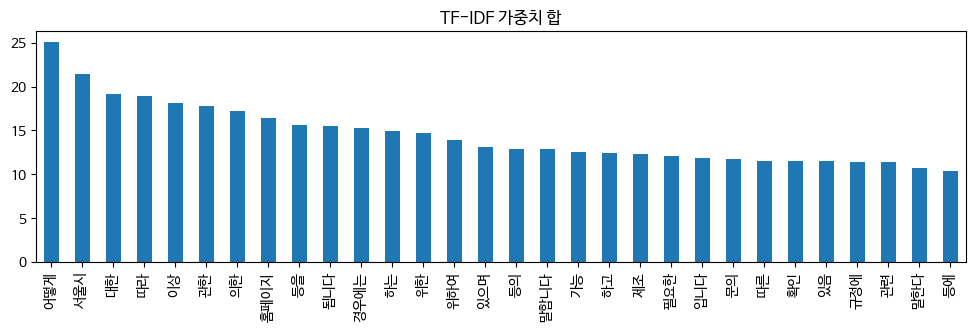

In [55]:
df_dtm.sum().nlargest(30).plot(kind='bar', figsize=(12,3), title='TF-IDF 가중치 합')

In [56]:
LDAModel = LatentDirichletAllocation(n_components=10, random_state=42)

In [57]:
W = LDAModel.fit_transform(X)
W

array([[1.23466328e-03, 9.88887370e-01, 1.23478533e-03, ...,
        1.23479357e-03, 1.23468723e-03, 1.23468660e-03],
       [2.32582636e-03, 2.32575393e-03, 9.79067879e-01, ...,
        2.32592505e-03, 2.32570262e-03, 2.32566751e-03],
       [9.25980498e-04, 9.91665932e-01, 9.26017664e-04, ...,
        9.26025121e-04, 9.26006597e-04, 9.26004268e-04],
       ...,
       [2.63174675e-03, 2.63189922e-03, 2.63193391e-03, ...,
        9.76313482e-01, 2.63174928e-03, 2.63174609e-03],
       [3.57203197e-03, 3.57183920e-03, 3.57196180e-03, ...,
        3.57168114e-03, 9.67852926e-01, 3.57224386e-03],
       [5.00022731e-03, 5.00031539e-03, 5.00050049e-03, ...,
        5.00021707e-03, 9.54997721e-01, 5.00013988e-03]])

In [58]:
H = LDAModel.components_
H

array([[0.1       , 0.1       , 0.1       , ..., 0.1       , 0.1       ,
        0.1       ],
       [0.1       , 0.1       , 0.1       , ..., 0.1       , 1.09999975,
        0.1       ],
       [0.1       , 0.1       , 0.1       , ..., 0.1       , 0.1       ,
        0.1       ],
       ...,
       [0.1       , 0.1       , 0.1       , ..., 0.1       , 0.1       ,
        0.1       ],
       [1.1       , 1.1       , 0.1       , ..., 1.1       , 0.1       ,
        0.1       ],
       [0.1       , 0.1       , 0.1       , ..., 0.1       , 1.1       ,
        0.1       ]])

In [59]:
df_lda_w = pd.DataFrame(W)
df_lda_h = pd.DataFrame(H, columns=cvect.get_feature_names_out())

df_lda_w['content'] = df['내용']
df_lda_w['label'] = df['분류']
df_lda_w.head(10).style.background_gradient(axis=1)

,0,1,2,3,4,5,6,7,8,9,content,label
0,0.001235,0.988887,0.001235,0.001235,0.001235,0.001235,0.001235,0.001235,0.001235,0.001235,아빠 육아휴직 장려금 업무개요 남성근로자의 육아휴직을 장려하고 양육에 따른 경제적 부담을 완화함으로써 일과 가정생활의 양립 및 가족친화적인 사회환경 조성 지원대상 신청일 기준 년 이상 계속하여 서초구에 주민등록 되어 있는 아빠 육아휴직자 대상자녀 서초구에 주민등록 된 경우 신청기간 육아휴직 시작일 이후 개월부터 종료일 이후 개월 이내 신청방법 온라인 서초구청 홈페이지 경로 서초구청 홈페이지 분야별정보 복지 영유아복지 아빠육아휴직장려금 신청 바로가기 방문 동주민센터 구 여성보육과 방문 구비서류 고용센터 발행 육아휴직급여 지급결정 통지서 부 주민등록등본 부세대원 이름과 전입일자 포함 모든 구성원 주민번호 뒷자리 미포함 지원내용 매월 만원지원기간 최대 년,복지
1,0.002326,0.002326,0.979068,0.002326,0.002326,0.002326,0.002326,0.002326,0.002326,0.002326,서울산업진흥원 서울메이드란 서울의 감성을 담은 다양하고 새로운 경험을 제공하기 위해 만들어진 라이프스타일 플랫폼 브랜드로 서울이 만들고 세계가 함께 쓰는 브랜드 입니다 서울의 감성을 담은 기업과 협업하여 브랜드 상품을 발굴 사용을 원하는 중소기업에게 서울메이드 브랜드 제공 등 관련홈페이지 서울메이드 상세문의사항 서울산업진흥원 브랜드전략팀,경제
2,0.000926,0.991666,0.000926,0.000926,0.000926,0.000926,0.000926,0.000926,0.000926,0.000926,강북구 정비중 업무개요 투명 폐트병을 교환보상하므로 수거율을 높이고 폐기물을 감량하여 환경 보호에 기여 업무설명 강북구 투명 페트병 종량제봉투 교환 사업 안내 구분 내용 사업기간 교환품목 투명 페트병 유색 페트병 일회용 컵 요구르트 식품 포장용기 식용유 양념류 제외 대상 관내 구민 누구나 교환장소 관내 동 주민센터 방문 교환 목요일 한정 처리방법 투명 페트병 개당 종량제봉투 장 교환 이하 개당 장 교환 이상 개당 장 교환 유의사항 물로 헹구고 비닐을 제거한 뒤 찌그러트려 뚜껑을 닫은 제품만 교환 뚜껑만 별도 재활용하는 단체에 가져다주는 경우 있음 뚜껑 꼭 안 닫아도 교환 가능 까지의 교환 실적을 토대로 각 동별 우수자 명에게 투명 페트병 재활용 제품 증정 단 강북구민 한정 타 동 실적 중복 인정하지 않음 예 김아무개 수유동 개 등 수유동 개 등으로 개 동 우수자여도 제품은 하나만 증정,환경
3,0.000735,0.000735,0.000735,0.000735,0.964832,0.000735,0.029284,0.000735,0.000735,0.000735,광진맘택시 운영임산부영아 양육가정 전용 택시 업무개요 교통약자인 임산부와 영아가정 주민이 병원 진료를 받으러 갈 떄 쾌적하고 안전하게 이동할 수 있도록 광진맘택시 운영 대상자 광진구에 주민등록을 한 임산부 및 개월 이하 자녀를 둔 가정 신청일 해당월의 개월 이전 출생자부터 이용가능 함 예 년 월 일 회원가입 신청 시 년 월 출생자부터 대상 지원내용 가정당 만원 택시이용권 이용시기 진료 또는 건강관리 목적 이동 및 귀가 시 사용 병원 의원 한의원 약국 보건소 산후조리원 임산부아기 건강프로그램임산부 요가 아기 마사지 등 진행시설 이용방법 신청서 제출 후 앱 설치 택시 이용 증빙자료 제출 신청서 확인서류 제출 동 주민센터 방문 또는 이메일 월 부터는 앱택시으로 신청서 제출 가능 신청서 다운로드 경로 광진구청 홈페이지 분야별복지 생애주기별복지 보육여성 여성임산부 지원 광진맘택시 바로가기 서비스 운영사 앱 설치 및 회원가입 앱 설치방법 안드로이드 플레이스토어 아이폰 에서 아이엠택시 검색 및 다운로드 앱 호출 후 이용 본인 계정 내 쿠폰 확인 후 쿠폰 결제 택시 이용 후 일 내 증빙자료병원영수증 또는 진료확인서 등 제출 제출방법 이메일 신청기간 월 금 월 부터는 앱택시으로 신청서 제출 가능 신청회차 신청기간 쿠폰 부여일 차 월 금 목 차 월 금 목 차 월 금 목 차 월 금 목 차 월 금 화,복지
4,0.001429,0.001429,0.987140,0.001429,0.001429,0.001429,0.001429,0.001429,0.001429,0.001429,마포 뇌병변장애인 비전센터 마포뇌병변장애인 비전센터 운영 구분 내용 목적 학령기 이후 갈 곳이 없는 중증 뇌병변 장애인의 교육돌봄건강 등 맞춤종합서비스 제공 대상자 만세 이상 만세 미만 중증중복 뇌병변 장애인 이용시간 평일 실 수업시간 이용료 월 원식비 별도 기초생활수급자 무료 차상위계층 감면식비 별도 지원내용 개별 특성 및 욕구를 기반으로 한 교육 돌봄 건강 등의 종합서비스 이용방법 이용자 모집 기간에 유선으로 예약 후 내방하여 접수 문의처 마포뇌병변장애인비전센터 마포구 신촌로 길 우리마포복지관 층 기타사항 상세 문의는 마포뇌병변장애인비전센터로 문의,복지
5,0.000485,0.000485,0.995631,0.000485,0.000485,0.000485,0.000485,0.000486,0.000485,0.000485,년도 중고 신입생 입학준비금 지원 업무개요 서울시는 전국 최초로 년도부터 개 자치구 교육청과 협력하여 서울 관내 국공사립 중 고고등기술 특수각종학교에 입학하는 학생들을 대상으로 입학준비금을 지원하여 신입생 가정에 경제적 부담 감소 및 소득에 관계없이 교복 등 의류 스마트기기를 지원하여 교육의 공공성 강화 및 보편적 교육복지를 실현하고자 함 업무설명 입학준비금 지급방식은 각 학교에서 학생학부모의 신청을 받아 교복구매 지원 또는 제로페이 모바일 포인트를 지급하는 방식이며 구입범위는 교복 생활복 체육복 일상 의류등교에 필요한 의류 원격수업에 필요한 스마트기기 구매가능 신청 날짜 및 지급방법 등의 문의는 각 학교에서 진행되므로 해당학교로 문의해야함 년 중고등학교 입학준비금 사용 범위 구분 의류 스마트기기 구매범위 교복 생활복 체육복 일상 의류등교에 필요한 의류 태블릿 노트북 포함 원격수업에 필요한 스마트 기기 비고 교복 구매 시 학교별 학칙에서 정한 교복 형태에 따라 추진 온라인 수업 과제용 등록된 제로페이 가맹점을 방문하여 구매 가능 교육의 공공성 강화와 교육복지를 실현하기 위한 사업으로 중고 신입생의 교육 준비에 필수적인 물품으로 제한됨 지원대상 지원 대상 년 국공사립 중 고고등기술 특수 각종학교 신입생 전원 지원금액 인당 만원학교로 예산 교부 교복구매 지원 및 포인트 지급 사용방법 학교주관구매 교복비로 사용 학교에서 교복비로 지원 처리 주관구매 교복 외 등교의류와 스마트기기 구매교복물려입기 포함 제로페이로 사용코드 방식의 모바일 간편 결제 서비스 활용 중학생의 경우 학부모에게 지급세 미만 제로페이 지급 불가 기타사항 서울시에 신고 수리된 개 비인가 대안교육기관에 입학하는 학교 밖 청소년의 경우에도 공교육 학생들과 같은 방식인 제로페이 포인트로 부모 소득과 관계없이 만 원씩 지급될 예정이다,행정
6,0.000544,0.000544,0.000544,0.995108,0.000544,0.000544,0.000544,0.000544,0.000544,0.000544,위드유 서울 직장 성희롱성폭력 예방센터 업무개요 직장 내 성희롱 지원체계 사각지대에 있는 서울 시민이 안전하고 성평등하게 일할 수 있는 환경 조성 민관 협력을 통해 성희롱 예방 및 피해자 지원 체계 강화 업무설명 서울 직장 성희롱성폭력 예방센터위드유 구분 내 용 직장 내 성희롱 예방교육 인 미만 소규모 사업장 내 성희롱 예방을 위한 맞춤형 교육 무료 지원 교육내용 성희롱의 개념과 원인 이해 조직 내 성평등 문화 점검 성희롱 고충사건의 분쟁해결절차 안내 신청방법 신청서 작성 후 이메일접수 사업장 조직문화 컨설팅 인 미만 소규모 사업장에 교육법률 전문가를 무료 매칭하여 조직문화 진단 및 솔루션 제공 컨설팅내용 조직문화 진단 내부 규정 개선방안 제시 신청방법 신청서 작성 후 이메일접수 피해지원 기반강화 직장 내 성희롱성폭력 예방 및 피해지원